In [1]:
from sdm.utils import set_project_wd
from sdm.data.os import generate_parquets
from sdm.geo import reproject_to_model_raster
import geopandas as gpd
import xarray as xr
from tempfile import NamedTemporaryFile
from sdm.geo import rasterise_gdf
import rioxarray as rxr
from shapely.geometry import box


set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


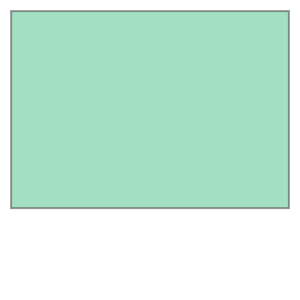

In [7]:
boundary = gpd.read_file("data/processed/boundary.geojson")
# Buffer the boundary by a few kms
boundary["geometry"] = box(*boundary.geometry.buffer(7000).bounds.values[0])
boundary.geometry[0]

In [10]:
datasets=["Building", "Water", "Woodland", "Road" ]
paths = generate_parquets(datasets, boundary = boundary.geometry[0], dir="data/raw/big-files/os-data", overwrite=False)

os_data = {name:gpd.read_parquet(path) for name, path in zip(datasets, paths)}

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/geopandas/io/arrow.py:337: UserWarning: The GeoDataFrame contains 3D geometries, and when using shapely < 2.0, such geometries will be written not exactly following to the GeoParquet spec (not using ISO WKB). For most use cases this should not be a problem (GeoPandas can read such files fine).
  table = _geopandas_to_arrow(df, index=index, schema_version=schema_version)
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/geopandas/io/arrow.py:337: UserWarning: The GeoDataFrame contains 3D geometries, and when using shapely < 2.0, such geometries will be written not exactly following to the GeoParquet spec (not using ISO WKB). For most use cases this should not be a problem (GeoPandas can read such files fine).
  table = _geopandas_to_arrow(df, index=index, schema_version=schema_version)
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/geopandas/io/arrow.py:337:

<Axes: >

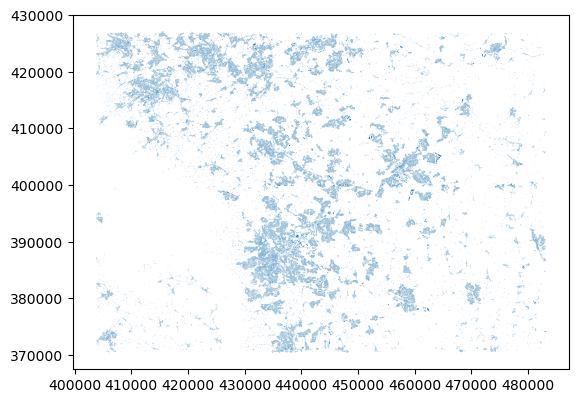

In [12]:
os_data["Building"].plot()

# Tidy Up the OS Datasets

## Major & Minor Roads

Classify the roads into major and minor roads which have different effects on bats. Major roads tend to deter bats and pose a collision risk. Minor roads can have a positive effect where they are associated with vegetation or lighting which can aid in foraging.

In [13]:
os_data["Road"].head()

,ID,FEATCODE,geometry,DISTNAME,ROADNUMBER,CLASSIFICA,DRAWLEVEL,OVERRIDE,dataset
21298,DA52CC22-7869-4262-88C7-E264B1E246CA,25750.0,"LINESTRING Z (482163.250 370508.980 0.000, 482...",Church Lane,None,Minor Road,0,F,Road
24884,80A982F6-56D4-4078-8FAF-5B6A6EC4AF2D,25750.0,"LINESTRING Z (473501.480 370584.810 0.000, 473...",Newcastle Street,None,Minor Road,0,F,Road
24886,7408AF5D-580B-46C2-9B64-CFE1AD9FEA3B,25760.0,"LINESTRING Z (473501.480 370584.810 0.000, 473...",None,None,Local Street,0,F,Road
24885,A21C9A5F-6438-44AF-B9E4-3C8DC1D7FD67,25760.0,"LINESTRING Z (473523.340 370597.260 0.000, 473...",None,None,Local Street,0,F,Road
21776,531661DC-89E6-4BEB-A03C-35C971ECDB87,25750.0,"LINESTRING Z (475159.870 371014.840 0.000, 475...",Marnham Road,None,Minor Road,0,F,Road


This code gets the unique road classifications and generates a true false variable if they match a regex pattern It is done on the unique values as this operation is faster and it takes advantage of the fast joins in pandas to broadcast the values across the entire series.

In [14]:
# Get Classes
road_classes = os_data["Road"]["CLASSIFICA"].value_counts()
major_roads = ["Motorway", "A Road"]
pattern =  "|".join([road_type + "*" for road_type in major_roads])
road_classes = road_classes.to_frame(name = "count").reset_index(names=["CLASSIFICA"])
# Match the pattern
road_classes["major_road"] = road_classes.CLASSIFICA.str.contains(pattern, regex=True)
road_classes.drop(axis = 1, labels = ["count"],  inplace=True)

# Join and broadcast the data
roads = gpd.GeoDataFrame(os_data["Road"].merge(
    road_classes, on = "CLASSIFICA", how="left"
))
major_roads = roads[roads.major_road == True]
minor_roads = roads[roads.major_road == False]

Compose a list of datasets to be rasterised and have cover calculated

In [15]:
feature_gdfs = {
    "major_roads" : major_roads,
    "minor_roads" : minor_roads,
    "woodland" : os_data["Woodland"],
    "water" : os_data["Water"],
    "buildings" : os_data["Building"]
}

# Rasterize & Calculate Cover

In [32]:
# Get a 1m raster of buildings to use in the veg height calculation
rasterise_gdf(feature_gdfs["buildings"], resolution=2, output_file="data/processed/buildings-01.tif", bbox = boundary.geometry[0].bounds)

'data/processed/buildings-01.tif'

In [16]:
import numpy as np

def calculate_cover(gdf, name="cover", target_resolution:int=100):
    with NamedTemporaryFile() as f:
        rasterise_gdf(gdf, resolution=1, output_file=f.name, bbox = boundary.geometry[0].bounds)
        # Load the cover raster
        cover = rxr.open_rasterio(f.name, chunks="auto")
        cover_area = cover.coarsen(x=target_resolution, y = target_resolution, boundary="trim").sum().compute()
            
    return cover_area.to_dataset(name=name)

cover_datasets = [calculate_cover(gdf, name, target_resolution=100) for name, gdf in feature_gdfs.items()]

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/xarray/core/rolling.py:1026: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  reduced = self.obj.variable.coarsen(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/xarray/core/rolling.py:1026: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)



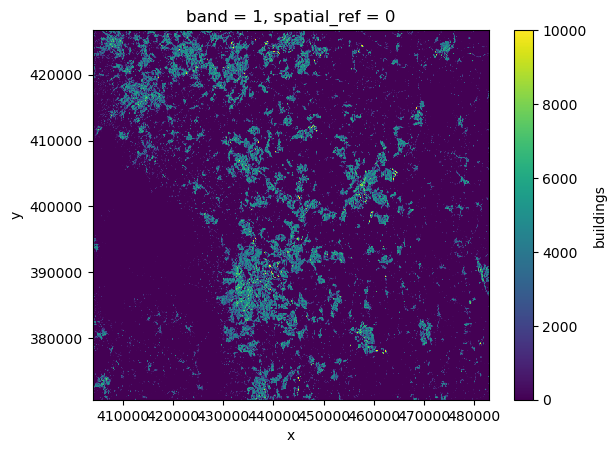

In [17]:
feature_cover = xr.merge(cover_datasets)
feature_cover.buildings.plot()

In [18]:
# Mask the data
import numpy as np
feature_cover_clipped =  feature_cover.rio.clip([boundary.geometry[0]], crs = boundary.crs)

Tidy up for writing a file

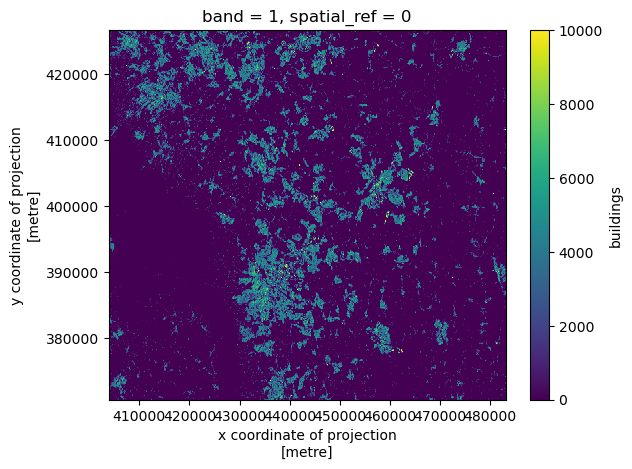

In [19]:
feature_cover_clipped = feature_cover_clipped.where(feature_cover_clipped != 255, np.nan)
feature_cover_clipped = feature_cover_clipped.squeeze()
feature_cover_clipped.buildings.plot()

In [20]:
feature_cover_clipped = reproject_to_model_raster(feature_cover_clipped)
feature_cover_clipped.rio.to_raster("data/evs/os-feature-cover-100m.tif")

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


# Distance Matrixes

## Create the Point Grid

In [21]:
# Create a grid of points
import geopandas as gpd
from sdm.geo import generate_point_grid
bbox = tuple(boundary.total_bounds)
resolution = 100
boundary_grid = generate_point_grid(bbox, resolution, crs = boundary.crs)
boundary_grid["x"] = boundary_grid.geometry.x
boundary_grid["y"] = boundary_grid.geometry.y
boundary_grid.head()

,geometry,x,y
0,POINT (403864.879 370493.562),403864.879459,370493.561784
1,POINT (403964.879 370493.562),403964.879459,370493.561784
2,POINT (404064.879 370493.562),404064.879459,370493.561784
3,POINT (404164.879 370493.562),404164.879459,370493.561784
4,POINT (404264.879 370493.562),404264.879459,370493.561784


## Create the Feature Points

In [22]:
# Convert the feature cover to a dataframe.
# Get the points which are >0 (there is feature cover)
# Then convert to a geo dataframe of points
cover_df = feature_cover_clipped.to_dataframe()
cover_df.drop(axis=1, labels=["spatial_ref", "band"], inplace=True)
cover_df = cover_df.stack().reset_index()
cover_df.rename(columns={"level_2" : "feature", 0 : "cover"}, inplace=True)
cover_df = cover_df[cover_df.cover > 0]

cover_df = gpd.GeoDataFrame(cover_df, geometry=gpd.points_from_xy(cover_df.x, cover_df.y), crs = boundary.crs)

cover_df.head()

,x,y,feature,cover,geometry
1,403914.879459,426696.051974,minor_roads,100.0,POINT (403914.879 426696.052)
4,403914.879459,426696.051974,buildings,1601.0,POINT (403914.879 426696.052)
6,403914.879459,426595.958408,minor_roads,100.0,POINT (403914.879 426595.958)
8,403914.879459,426595.958408,water,327.0,POINT (403914.879 426595.958)
9,403914.879459,426595.958408,buildings,4727.0,POINT (403914.879 426595.958)


### Calculate the Distance Matrix

In [23]:
from scipy.spatial import cKDTree
import numpy as np

grid_points = np.array(boundary_grid[["x", "y"]])

# For every point in the grid, get the distance to the nearest feature point
def get_shortest_distance(grid_xy, feature_xy):
    tree = cKDTree(feature_xy)
    dist, idx = tree.query(grid_xy, k=1)
    return dist

# Loop through the features and get the distance to the nearest feature point
distance_to_feature = {}
for feature in cover_df.feature.unique():
    feature_points = np.array(cover_df[cover_df.feature == feature][["x", "y"]])
    boundary_grid[f"distance_to_{feature}"] = get_shortest_distance(grid_points, feature_points)

boundary_grid.head()

,geometry,x,y,distance_to_minor_roads,distance_to_buildings,distance_to_water,distance_to_woodland,distance_to_major_roads
0,POINT (403864.879 370493.562),403864.879459,370493.561784,1152.114692,1260.090806,291.743408,353.782875,3519.406139
1,POINT (403964.879 370493.562),403964.879459,370493.561784,1152.114692,1252.124234,255.147948,291.778754,3470.732773
2,POINT (404064.879 370493.562),404064.879459,370493.561784,1160.761932,1252.118747,255.121020,255.161439,3424.288596
3,POINT (404164.879 370493.562),404164.879459,370493.561784,1177.865979,1252.116009,255.107582,255.107582,3380.165499
4,POINT (404264.879 370493.562),404264.879459,370493.561784,1203.066193,1236.004980,255.094163,255.094163,3338.455512


# Tidy Up

check for nulls and infs

In [24]:
# Check for inf values in each column
boundary_grid.isin([np.inf]).sum()

geometry                   0
x                          0
y                          0
distance_to_minor_roads    0
distance_to_buildings      0
distance_to_water          0
distance_to_woodland       0
distance_to_major_roads    0
dtype: int64

### Convert to xarray

In [25]:
# Order the points in the grid by coordinates then convert it to an xr dataset
boundary_grid = boundary_grid.sort_values(["y", "x"])
boundary_grid = boundary_grid.set_index(["y", "x"])
distance_array = boundary_grid.to_xarray()
# Set the crs
distance_array = distance_array.rio.write_crs(boundary.crs)
# Clip to the boundary to reduce edge effects
distance_array = distance_array.rio.clip([boundary.geometry[0]], crs = boundary.crs)
# Drop the geometry variable in the xarray dataset
distance_array = distance_array.drop_vars(["geometry"])

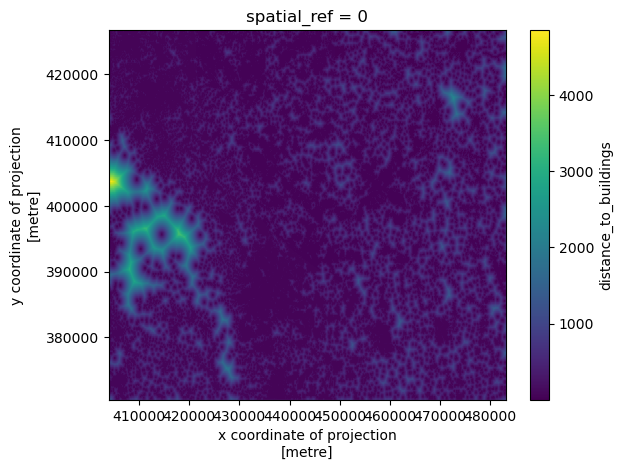

In [26]:
distance_array.distance_to_buildings.plot()

In [27]:
distance_array = reproject_to_model_raster(distance_array)
distance_array.rio.to_raster("data/evs/os-distance-to-feature.tif", dtype="float64")

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
